In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from ucimlrepo import fetch_ucirepo


In [8]:
# new preprocessing

df = pd.read_csv("diabetic_data.csv")
df.drop_duplicates(subset="patient_nbr", keep="first", inplace=True)
X = df.drop(['encounter_id','patient_nbr','readmitted'], axis = 'columns')
y = df["readmitted"]
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = math.ceil((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i + 1})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# plotPerColumnDistribution(X, 15, 5)
columns_to_drop = ['weight', 'payer_code', 'medical_specialty']

# drop features: weight, payer_code, medical_specialty, max_glu_serum, A1Cresult
X = X.drop(columns=columns_to_drop)
X.drop(X[X['gender'] == 'Unknown/Invalid'].index, inplace=True)

# labels = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
#           'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
def map_icd_to_category(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return "Other"
    if 390 <= icd_code <= 459 or icd_code == 785:
        return 'Circulatory'
    elif 460 <= icd_code <= 519 or icd_code == 786:
        return 'Respiratory'
    elif 520 <= icd_code <= 579 or icd_code == 787:
        return 'Digestive'
    elif str(icd_code).startswith('250'):
        return 'Diabetes'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    # Musculoskeletal
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    # Genitourinary
    elif 580 <= icd_code <= 629 or icd_code == 788:
        return 'Genitourinary'
    # Neoplasms
    elif 140 <= icd_code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

X['diag_1'] = X['diag_1'].apply(map_icd_to_category)
X['diag_2'] = X['diag_2'].apply(map_icd_to_category)
X['diag_3'] = X['diag_3'].apply(map_icd_to_category)

categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_encoded = pd.concat([X_encoded, X.drop(columns=categorical_columns)], axis=1)

column_variances = X_encoded.var()
nzv = set()
# set of near zero variance features
for column, variance in column_variances.items():
    if variance < .001:
        nzv.add(column.split('_')[0])

columns_to_drop = []
for column in X_encoded.columns:
    parts = column.split('_')
    if parts[0] in nzv:
        columns_to_drop.append(column)

X_encoded = X_encoded.drop(columns=columns_to_drop)
missing_values = X_encoded.isnull().any(axis=1)
y = y.reset_index(drop=True)
X_encoded = X_encoded[~missing_values]
y = y[~missing_values]

y = y.map({'<30': 1, '>30': 0, 'NO': 0})

# pd.set_option('display.max_columns', None)
# print(X_encoded.head(1000))
print("After preprocessing...")
print("Number of features: ", X_encoded.shape[1])
print("Number of patients: ", len(y))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


After preprocessing...
Number of features:  96
Number of patients:  52671


In [3]:
# old preprocessing

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

columns_to_drop = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

# drop features: weight, payer_code, medical_specialty, max_glu_serum, A1Cresult
X = X.drop(columns=columns_to_drop)
X.drop(X[X['gender'] == 'Unknown/Invalid'].index, inplace=True)
# results in 105 column features after transform

# labels = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury',
#           'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
def map_icd_to_category(icd_code):
    try:
        icd_code = float(icd_code)
    except ValueError:
        return "Other"
    if 390 <= icd_code <= 459 or icd_code == 785:
        return 'Circulatory'
    elif 460 <= icd_code <= 519 or icd_code == 786:
        return 'Respiratory'
    elif 520 <= icd_code <= 579 or icd_code == 787:
        return 'Digestive'
    elif str(icd_code).startswith('250'):
        return 'Diabetes'
    elif 800 <= icd_code <= 999:
        return 'Injury'
    # Musculoskeletal
    elif 710 <= icd_code <= 739:
        return 'Musculoskeletal'
    # Genitourinary
    elif 580 <= icd_code <= 629 or icd_code == 788:
        return 'Genitourinary'
    # Neoplasms
    elif 140 <= icd_code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

X['diag_1'] = X['diag_1'].apply(map_icd_to_category)
X['diag_2'] = X['diag_2'].apply(map_icd_to_category)
X['diag_3'] = X['diag_3'].apply(map_icd_to_category)

categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_encoded = pd.concat([X_encoded, X.drop(columns=categorical_columns)], axis=1)

column_variances = X_encoded.var()
nzv = set()
# set of near zero variance features
for column, variance in column_variances.items():
    if variance < .001:
        nzv.add(column.split('_')[0])

columns_to_drop = []
for column in X_encoded.columns:
    parts = column.split('_')
    if parts[0] in nzv:
        columns_to_drop.append(column)

X_encoded = X_encoded.drop(columns=columns_to_drop)

missing_values = X_encoded.isnull().any(axis=1)
X_encoded = X_encoded[~missing_values]
y = y[~missing_values]

y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})

# pd.set_option('display.max_columns', None)
# print(X_encoded.head(1000))


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\loren\AppData\Local\Temp\ipykernel_18784\1270677017.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['readmitted'] = y['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})


In [5]:
# logistic_classifier
train_accuracies = []
test_accuracies = []
conf_matrices = []
cs = [0, 0.1, 1, 10, 50]
for c in cs:
    if c == 0:
        classifier = LogisticRegression(penalty=None, max_iter=1000, fit_intercept=True)
    else:
        classifier = LogisticRegression(penalty='l1', C=c, max_iter=1000, solver='liblinear', fit_intercept=True)
    classifier.fit(X_train, y_train)
    train_accuracies.append(classifier.score(X_train, y_train))
    test_accuracies.append(classifier.score(X_val, y_val))
    conf_matrices.append(confusion_matrix(y_val, classifier.predict(X_val)))

c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\dev\diabetes-classifiers\env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was pass

[0.617269392033543, 0.6170564727463312, 0.617269392033543, 0.6173349056603774, 0.6173185272536688] [0.617875393081761, 0.6177279874213837, 0.6179245283018868, 0.617875393081761, 0.617875393081761]


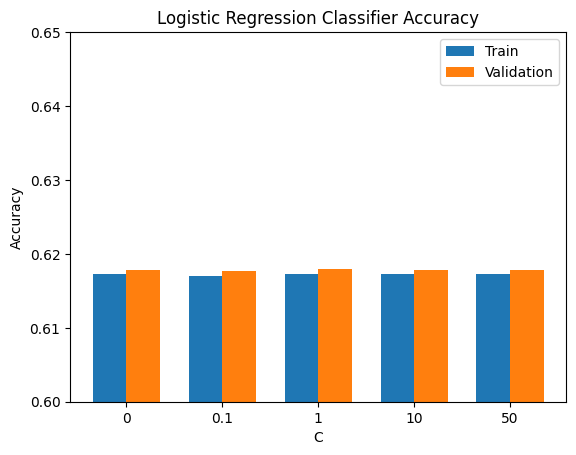

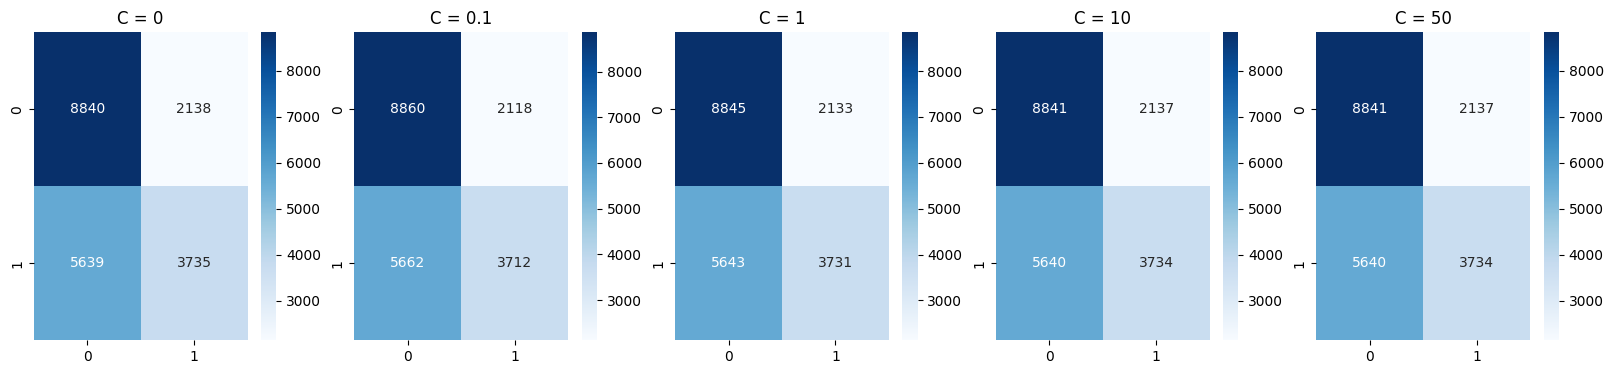

In [7]:
# logistic regression classifier plotting

# plot accuracies
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(cs))
train_bars = ax.bar(index, train_accuracies, bar_width, label='Train')
test_bars = ax.bar(index + bar_width, test_accuracies, bar_width, label='Validation')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Classifier Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cs)
ax.set_ylim(0.6, 0.65)
ax.legend()


# plot confusion matrix
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'C = {cs[i]}')


In [ ]:
# kNN classifier
# figure, axes = plt.subplots(1, figsize=(6, 6))
# train_accuracies, test_accuracies = [], []
# k_values = [1, 2, 5, 10, 50, 100, 110]
# for k in k_values:
#     classifier = KNeighborsClassifier(n_neighbors=k)
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_train)
#     train_acc = accuracy_score(y_train, y_pred)
#     train_accuracies.append(train_acc)
#     y_pred = classifier.predict(X_val)
#     test_acc = accuracy_score(y_val, y_pred)
#     test_accuracies.append(test_acc)
# axes.semilogx(k_values, train_accuracies, marker='o', color='red')
# axes.semilogx(k_values, test_accuracies, marker='o', color='green')
# plt.show()

In [ ]:
# k = 5 was the best performing k-value from the previous code
# classifier = KNeighborsClassifier(n_neighbors=5)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# y_pred_prob = classifier.predict_proba(X_test)[:, 1]
# test_acc = accuracy_score(y_test, y_pred)
# test_pre = precision_score(y_test, y_pred)
# test_rec = recall_score(y_test, y_pred)
# test_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"Test Accuracy: {test_acc}\nTest Precision: {test_pre}\nTest Recall: {test_rec}\nTest AUC: {test_auc}")

In [ ]:
# neural network
# train_accuracies = []
# val_accuracies = []
# learning_rates = [.001, .0025, .005, .0075, .01]
# for learning_rate in learning_rates:
#     mlp_model = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='sgd', learning_rate_init=learning_rate, batch_size=256, random_state=42)
#     mlp_model.fit(X_train, y_train)
#     mlp_train_pred = mlp_model.predict(X_train)
#     mlp_val_pred = mlp_model.predict(X_val)
#     mlp_train_acc = accuracy_score(y_train, mlp_train_pred)
#     mlp_val_acc = accuracy_score(y_val, mlp_val_pred)
#     train_accuracies.append(mlp_train_acc)
#     val_accuracies.append(mlp_val_acc)
# plt.plot(learning_rates, train_accuracies, marker='o', label='Training Accuracy')
# plt.plot(learning_rates, val_accuracies, marker='o', label='Validation Accuracy')
# plt.xlabel('Learning Rate')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Learning Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# random forest
# rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=4, min_samples_leaf=1, random_state=42)
# rf_classifier.fit(X_train, y_train)
# y_pred = rf_classifier.predict(X_test)
# y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
# test_acc = accuracy_score(y_test, y_pred)
# test_pre = precision_score(y_test, y_pred)
# test_rec = recall_score(y_test, y_pred)
# test_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"Test Accuracy: {test_acc}\nTest Precision: {test_pre}\nTest Recall: {test_rec}\nTest AUC: {test_auc}")

# param_grid = {
#     'n_estimators': [50, 100, 200],  # Number of trees in the forest
#     'max_depth': [None],     # Maximum depth of the tree
#     'min_samples_split': [2, 4, 6, 8], # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4, 8]   # Minimum number of samples required to be at a leaf node
# }
#
# rf_classifier = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

# k-fold cross validation for rf
# rf_classifier = RandomForestClassifier(n_estimators=200,
#                                         max_depth=None,        # Adjust max_depth
#                                         min_samples_split=2, # Adjust min_samples_split
#                                         min_samples_leaf=1,  # Adjust min_samples_leaf
#                                         random_state=42)
#
# cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
# print("Cross-Validation Scores:", cv_scores)
# mean_cv_score = np.mean(cv_scores)
# print("Mean Cross-Validation Score:", mean_cv_score)
#
# plt.figure(figsize=(5, 4))
# y_pred = rf_classifier.predict(X_test)
# print(accuracy_score(y_test, y_pred))
# cm = confusion_matrix(y_test, y_pred)
#
# conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
#
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=['Green'], cbar=False,
#             linewidths=0.1, annot_kws={'size': 16})
#
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.show()